<a href="https://colab.research.google.com/github/zzwony/Start_0920/blob/main/01_02_object_detection_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### YOLOv5
https://github.com/ultralytics/yolov5.git


안전모 데이터셋: https://public.roboflow.com/object-detection/hard-hat-workers


In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

In [3]:
%mkdir /content/yolov5/hhw
%cd /content/yolov5/hhw

/content/yolov5/hhw


In [ ]:
# curl은 커맨드 아린용 데이터 전송 도구. -L 옵션을 사용하여 HTTP 위치 헤더를 따르기(리다이렉션을 따르도록 curl을 사용할 수 있음)
!curl -L "https://public.roboflow.com/ds/f8Ixy0vaui?key=qGdw0xIzKi" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# yolov5s.pt를 적용하여 추가 학습없이 detecting
%cd /content/yolov5

!python detect.py --weights yolov5s.pt --img 416 --conf 0.25 --source hhw/test/images/

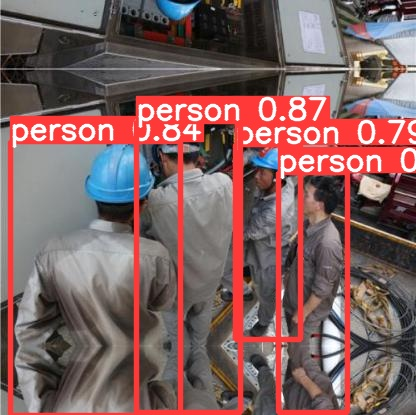

In [9]:
# 랜덤으로 뽑아서 볼 것이다.
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

person만 나오고 helmet은 안나온다.

In [ ]:
# 모델 만들기

In [ ]:
from glob import glob

train_img_list = glob('/content/yolov5/hhw/train/images/*.jpg')
test_img_list = glob('/content/yolov5/hhw/test/images/*.jpg')

In [ ]:
from sklearn.model_selection import train_test_split
test_img_list, valid_img_list = train_test_split(test_img_list, test_size=.5, random_state=777)
print(len(test_img_list), len(valid_img_list))

883 883


In [ ]:
with open('/content/yolov5/hhw/test.txt', 'w') as f:
  f.write('\n'.join(test_img_list)+'\n')

with open('/content/yolov5/hhw/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list)+'\n')

with open('/content/yolov5/hhw/valid.txt', 'w') as f:
  f.write('\n'.join(valid_img_list)+'\n')

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [ ]:
import yaml
%cat /content/yolov5/hhw/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['head', 'helmet', 'person']

In [ ]:
%%writetemplate /content/yolov5/hhw/data.yaml
train: ./hhw/train.txt
test: ./hhw/test.txt
val: ./hhw/valid.txt

nc: 3
names: ['head', 'helmet', 'person']

In [ ]:
%cat /content/yolov5/hhw/data.yaml

train: ./hhw/train.txt
test: ./hhw/test.txt
val: ./hhw/valid.txt

nc: 3
names: ['head', 'helmet', 'person']


In [ ]:
# 모델 구성
import yaml
with open('/content/yolov5/hhw/data.yaml', 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
num_classes

'3'

In [ ]:
%%writetemplate /content/yolov5/models/yolov5s.yaml  ## 새로운 모델 생성

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
!pwd

/content/yolov5


In [ ]:
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 32 --epochs 50 --data ./hhw/data.yaml --cfg ./models/yolov5s.yaml --weights '' --name hhw_results --cache

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!ls /content/yolov5/runs/train/hhw_results

In [ ]:
Image(filename='', width=-1000)

In [ ]:
# 검증
!python val.py --weigths /runs/train/hhw_results/weights/best.pt --data ./content/yolov5/hhw/data.yaml --img 416 --iou 0.65

In [ ]:
# 검증된 모델 사용
!python detect.py --weights /content/yolov5/runs/train/hhw_results/weights/best.pt --img 416 --conf 0.4 --source ./hhw/test/images

In [ ]:
# 모델 내보내기
%cp /content/drive/best.pt /content/yolov5

In [10]:
# 저장된 모델을 불러오기
%cp /content/drive/MyDrive/best.pt /content/yolov5

In [ ]:
# 저장된 모델로 detecting
!python detect.py --weights best.pt --img 416 --conf 0.25 --source hhw/test/images/

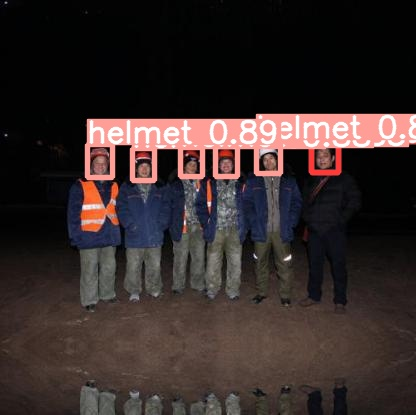

In [14]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'))
display(Image(filename=image_name))